In [2]:
import os 
import numpy as np
import healpy as hp 
import matplotlib.pyplot as plt
from scipy.special import sph_harm

import matplotlib.pyplot as plt 
from matplotlib import cm
cmap = cm.RdYlBu_r

from matplotlib import rcParams
rcParams["font.size"]=16
rcParams["figure.dpi"]=150
rcParams["text.usetex"]=True
rcParams["font.family"]="stix"

import warnings
warnings.filterwarnings('ignore')

Note: This tutorial does not attempt to review the physics of the cosmic microwave background and why it is such an enormously useful observable in cosmology. Check out these sources for some background (pun intended) info:

https://arxiv.org/pdf/1005.0555.pdf

http://background.uchicago.edu/

The goal of this tutorial is to explain what the CMB power spectrum represents. Hopefully by the end of this article you will have a good understanding of what this plot means:

![WMAP](data/wmap_power_spectrum.jpg)

---
> **Question:** What does the CMB temperature power spectrum represent? 

>*Short Answer*: It shows how much temperature fluctuation we have over various angular scales in the sky.

>*Long Answer*: Read on! 
---

Side Note: Some images in what follows were extracted from [Wikipedia](https://www.wikipedia.org/).

# The Cosmic Microwave Background (CMB)

## Mollweide Projection

We observe the [**cosmic microwave background (CMB)**](https://en.wikipedia.org/wiki/Cosmic_microwave_background) as incoming radiation in a spherical shell around us. This radiation is (almost) a perfect black body in every direction of the sky, so we can describe it with only one parameter: its **temperature $T$**.

The whole-sky map of the CMB is almost exclusively presented in a [mollweide projection](https://en.wikipedia.org/wiki/Mollweide_projection) like this:

![WMAP](data/WMAP_mollweide.png)


This is an image of a spherical shell, projected into a flat surface while preserving the area of all patches. If you've never seen this image before, the following one might look more familiar:


![Earth](data/Earth_mollweide.jpg)

The main difference between these two images is that for the Earth we are looking at the sphere from *outside*, while for the CMB we are embedded by the spherical shell so we are looking it from *inside*.

Ok, good! So the CMB is basically a function over a sphere. This means in every direction $\hat{n} = (\theta, \phi)$ that we look in the sky, we measure a temperature $T(\theta, \phi)$ for the CMB. Therefore, we can mathematically model the CMB temperature as a scalar function over a sphere. (Yes, the CMB is also polarized, but let's forget about that for now.)

## Harmonic Expansion

A common way to analyze this map is to first decompose it in terms of [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) $Y_{\ell m}(\theta,\phi) $s. The spherical harmonics form an orthogonal basis on the surface of a sphere, which makes them the perfect choice for decomposing the CMB temperature into [*independent*](https://en.wikipedia.org/wiki/Linear_independence) modes. 

\begin{equation}\label{eq:T_th_ph}
    \boxed {
    T(\theta,\phi) = \sum_{\ell,m} a^T_{\ell m} Y_{\ell m}(\theta, \phi)
    }
\end{equation}

The $a^T_{\ell m}$s are called the harmonic coefficients. 

Equation \eqref{eq:T_th_ph} breaks down the temperature field into various angular scales indicated by number $\ell$. We'll see this in more detail further on, but just to give you an idea, the harmonic mode $\ell$ corresponds with fluctuations on an angular scale $\boxed{\delta \theta \sim \pi/\ell}$. If this sounds too abstract, don't worry about it. We'll see what it means in a second. 

# Spherical Harmonics

Before we dive into expanding the CMB temperature in terms of [spherical harmonics](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics) $Y_{\ell m}$, let's take a minute to see what they look like on a sphere. I will use the [`healpy`](https://healpy.readthedocs.io/en/latest/) package to plot them in mollweide projection. 

The spherical harmonics function `sph_harm` from `scipy` is a bit weird in the way it defines the indeces and angles $\theta$ and $\phi$, so let's first write a wrapper for that to make it easier to use.  

In [3]:
def Y_lm(l, m, theta, phi):
    """Return the spherical harmonic function Y_{\ell m} (\theta,\ phi)"""
    
    return sph_harm(m,l,phi,theta)

---
> **Exercise:** Check out a few of the values returned by `Y_lm` with the ones found in the table here:
    https://en.wikipedia.org/wiki/Table_of_spherical_harmonics

---

Now let's plot the first few multipoles using `healpy`. NOTE: If you're new to `healpy` checkout the official [tutorial](https://healpy.readthedocs.io/en/latest/tutorial.html) for a quick review. 

In [4]:
# let's setup the healpy map

nside = 256 # fix the resolution of the map
npix = hp.nside2npix(nside) # get the number of pixels
theta, phi = hp.pix2ang(nside,np.arange(npix)) #get theta and phi for all pixels

Let's make sure this works... Don't worry if the following line of code is too ambiguous. The goal here is to understand the spherical harmonics, not to learn how to work with healpy. 

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


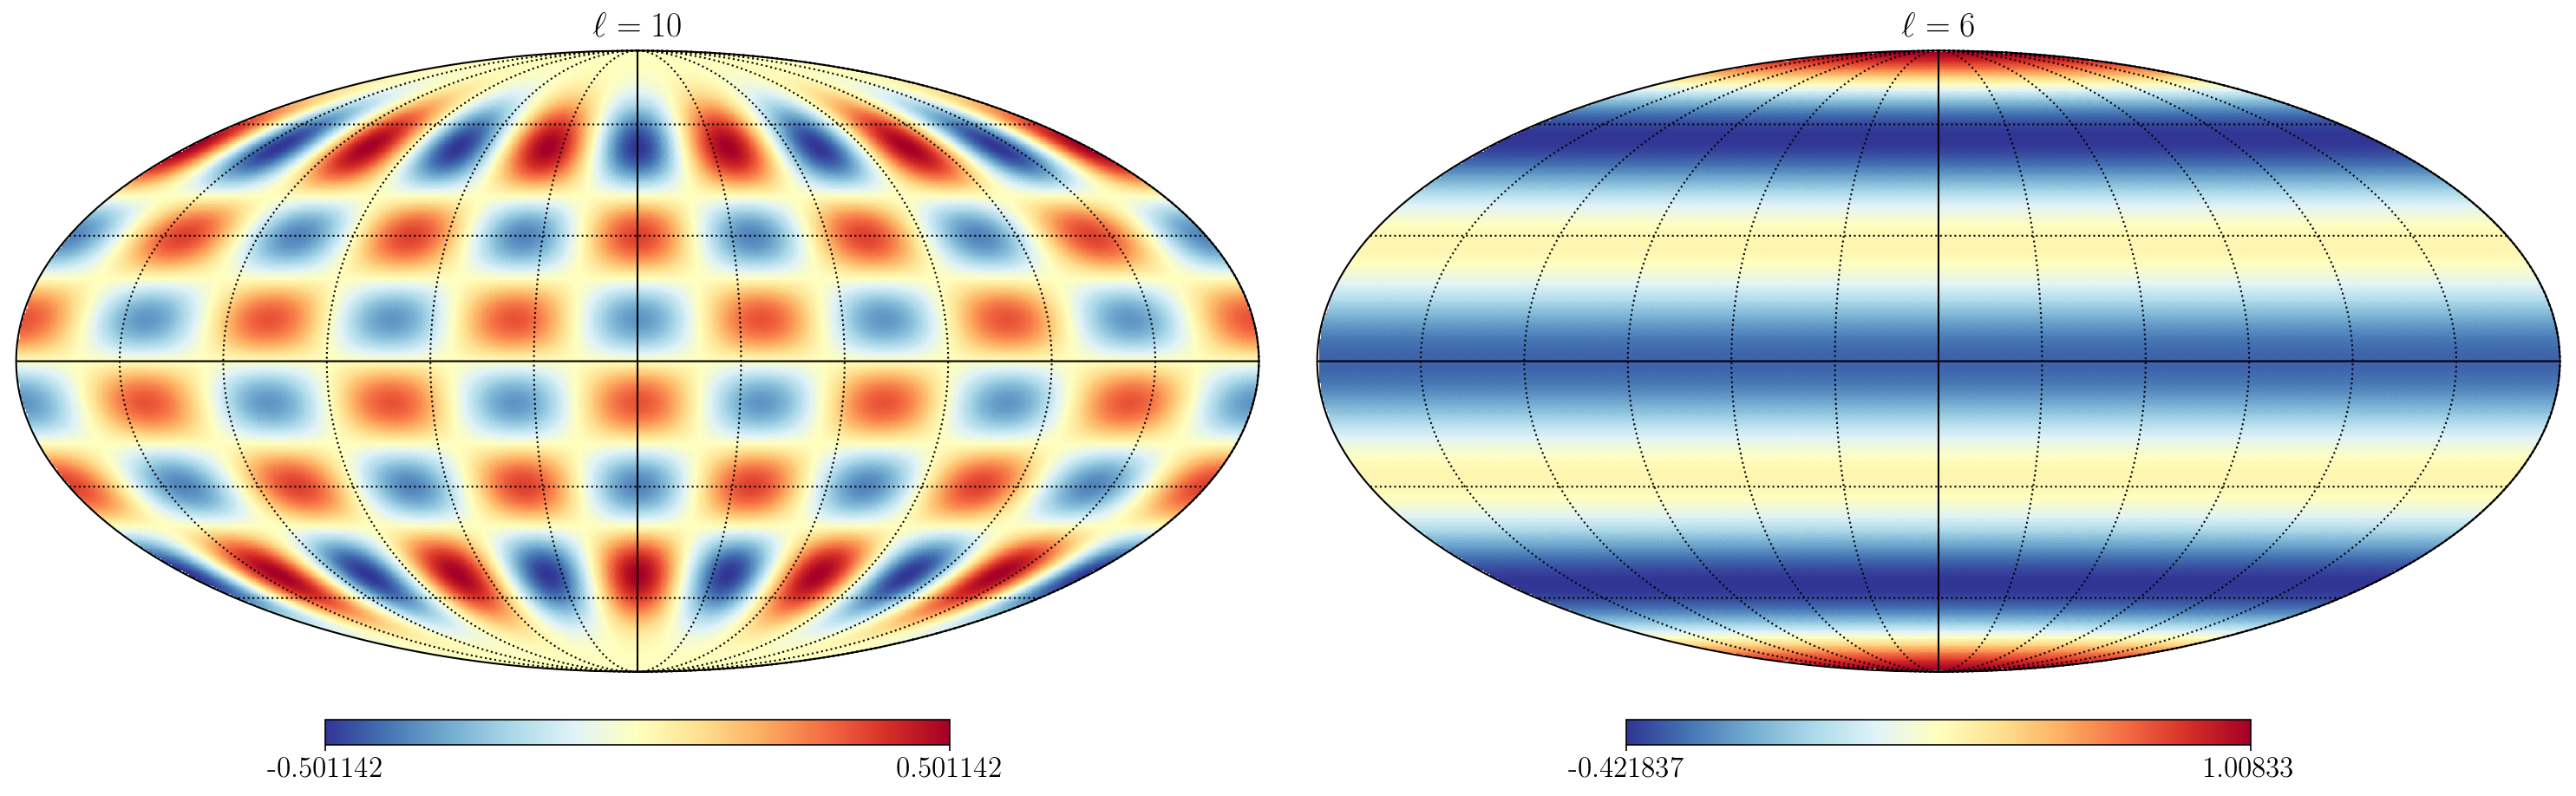

In [5]:
# plot two random modes like (l,m) = (10,5) and (6,0)
_ = plt.figure(figsize=(20,15))
hp.mollview(Y_lm(10,5,theta,phi), title="$\ell = 10$",cbar=True, sub=(2,2,1),cmap=cmap)
hp.mollview(Y_lm(6,0,theta,phi), title="$\ell = 6$",cbar=True, sub=(2,2,2),cmap=cmap)
hp.graticule()

Great! 

You can see that spherical harmonics are oscillaiting functions on a sphere; basically a bunch of sines and cosines ($\sim$ to the power $\ell$) that have wavelengths roughly equal to $\pi/\ell$.  

---
> **Exercise:** Try to confirm this fact using the gridlines on the plots.
---

As I mentioned previously, the first index $\ell$ determines the size of the angular fluctuations on the sphere. The second index is restricted to the range $-\ell \leq m \leq \ell$, which means for every $\ell$ there are *only* $2\ell+1$ independent $m$ modes. 

To make the visualization process easier, I'm going to define a function which will plot all the $2\ell+1$ modes for each given $\ell$.

In [6]:
def plot_multipole(ell,theta,phi, ):
    """plot all different m modes for the given l mode"""
    
    n = 2*ell+1 # number of independent modes
    
    # initialize an empty figure with the proper size 
    _ = plt.figure(figsize=(n*4,20))
    
    # find all the valid m modes
    em = np.arange(-ell, ell+1)
    
    # iterate through m modes and plot the corresponding Y_lm
    for m in em:
        Y = Y_lm(ell, m, theta, phi)
        hp.mollview(Y, 
                    sub=(2*ell+1,2*ell+1,m+ell+1),
                    title=f"($\ell,m$) = ({ell},{m})",
                    cbar=False,
                    cmap=cmap,
                   )

Now let's check out the first few multipoles

## $\ell = 0$ (Monopole)

For $\ell$ = 0 (and necesarily $m=0$) there is no angular dependence. $Y_{0,0}$ is a constant over the whole sphere. We typically refer to this mode as a monopole. This is what it looks like:


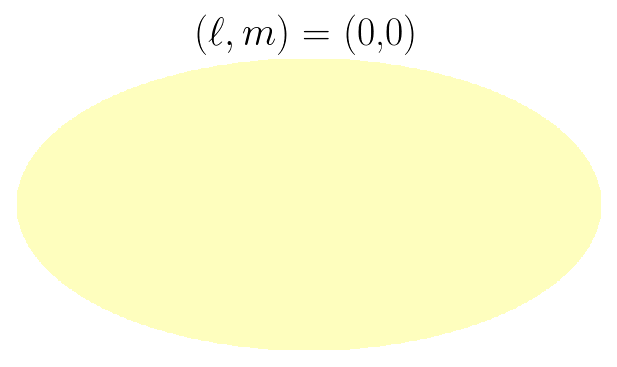

In [7]:
plot_multipole(0,theta,phi)

I hope this is what you expected. Let's move on to $\ell=1$.

## $\ell = 1$ (Dipole)

For $\ell=1$, refered to as the **dipole**, we have 3 independent $m$ modes: $m=-1, 0, 1$. 

Before I plot these modes, let me remind you of a little factoid that I mentioned previously. The number $\ell$ indicates the angular size of the oscillations for that particular mode, specifically $\delta \theta \sim \pi/
\ell$. So for $\ell=1$, we expect blobs that are of the angular size $\delta \sim \pi$, or in other words oscillations that have their peaks and troughs apart by $\pi$ radians (or 180 degrees). 

So when I plot the 3 dipole modes ($\ell =1$ and $m = -1, 0, 1$) we should expect the dark and bright spots in the map to be 180 degrees apart. Let's check this:


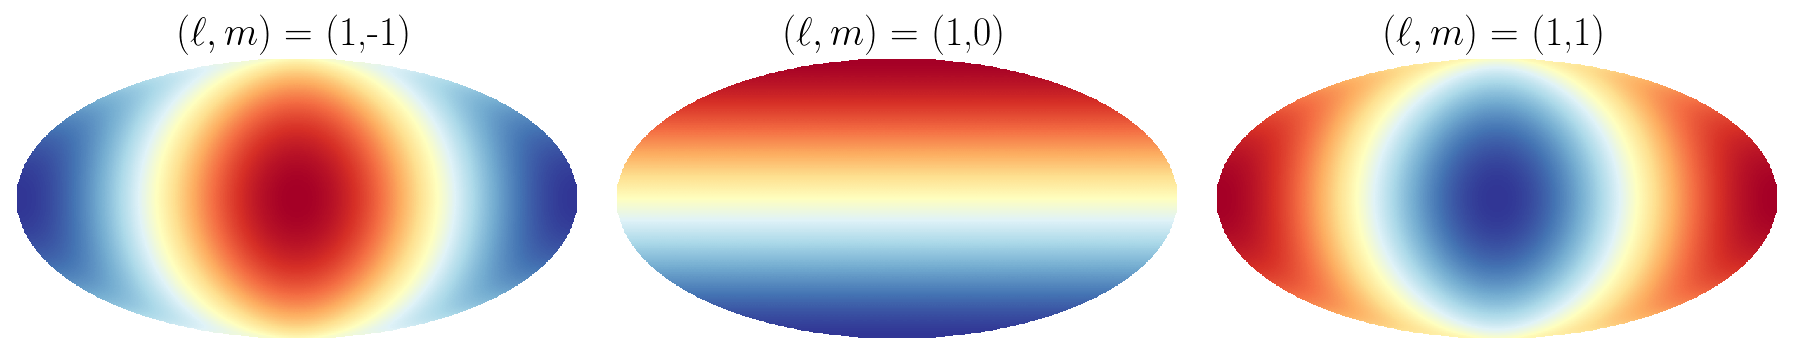

In [8]:
plot_multipole(1,theta,phi)

We can see from the middle panel very clearly that the bright (hot) and dark (cold) spots for $Y_{1,0}$ are at the opposite poles of the sphere, which means they are 180 degrees apart as expected. This is also true for the other two panels, but might not be immediately obvious if this is your first time looking at mollweide projections. The important thing to remember is that the right and left edge of the above maps are actually the same. If this is not exactly clear to you, check out the mollweide projection of the Earth again. 

## $\ell = 2$ (Quadrupole)

Ok, you get the idea...

For $\ell=2$ (named the **quadrupole**) we have 5 independent modes ($m=-2,-1,0,1,2$) and this is what they look like:

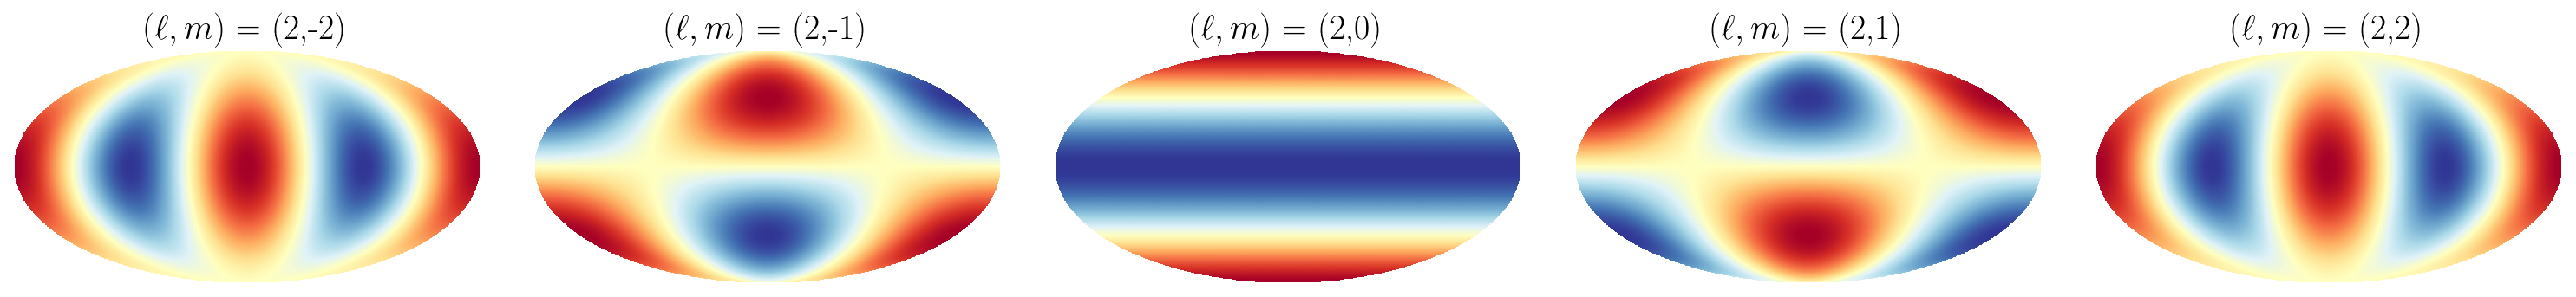

In [9]:
plot_multipole(2,theta,phi)

Are the peaks and troughs 90 degrees apart as you expected? 

## $\ell=3$ (Octupole)

---
> **Exercise:** Calculate the expected distance between the peaks and troughs (in other words the sie of the fluctuations) for the octupole modes and then plot it using the `plot_multipole` function. Did you get what you expected? 
---

## $\ell = 4$ (Hexadecapole)

I just made this subsection to point out the very nontrivial fact that $\ell=4$ is called the *hexadecapole*! (why? hint: $2^4=16$)

# Harmonics Expansion (continued...)

## Harmonic Multipoles 

Ok, enough with the spherical harmonics for now. Let's go back to the temperature map $T (\theta, \phi)$. Now that you have a better (or a general) idea of what the spherical harmonics are and how they behave, you can understande the ide behind the following expansion:

\begin{equation}\label{eq:T_expansion}
    T(\theta,\phi) = \sum_{\ell,m} a^T_{\ell m} Y_{\ell m}(\theta, \phi),
\end{equation}

or to write it in a more expressive way 

\begin{equation}
    T(\theta,\phi) = a^T_{0,0} Y_{0,0}(\theta, \phi) + \sum_{m=-1}^{1} a^T_{1,m} Y_{1,m}(\theta, \phi) +  \sum_{m=-2}^{2} a^T_{2,m} Y_{2,m}(\theta, \phi) + ...
\end{equation}

You can translate this expansion to something like 


\begin{equation}
    T(\theta,\phi) = \rm{this~much} \times \bf{monopole} + \rm{that~much} \times \bf{dipole}+  \rm{a~little~bit} \times \bf{quadrupole} + ...
\end{equation}

which is basically writing it as *the average (monopole)* plus the fluctuations over the angular scales of *180 degrees (dipole)*, *90 degrees (quadrupole)*, then *60 degrees (octupole)*, and so on and so forth. So we're breaking down the temperature fluctuations to specific angular sizes which are independent from each other. This is useful for the exact same reason that decomposing a three dimensional vector $\vec{v}$ into $\vec{v}_x$, $\vec{v}_y$, and $\vec{v}_z$ when solving mechanics problems: we split a complicated object into smaller independent pieces that are easier to handle. 

*Side Note:* Harmonic expansion is basically the [Fourier transform](hhttps://en.wikipedia.org/wiki/Fourier_transform) of the temperature field from real space to angular space. If you are already familiar with the concept of Fourier analysis then you should have no problem drawing a parallel between the two. If this is completely new territory for you wikipedia is always a good place to start!



---
>**Exercise:** Use the fact that temperature $T(\theta, \phi)$ is always real (meaning $T$ and its complex conjugate $T^*$ are the same), find the relationship between the harmonic coefficient $a^T_{\ell m}$ and its complex conjugate $a^{T*}_{\ell m}$.

>Hint: you might want to check out the definition of the spherical harmonics in terms of Legendre polynomials. 
---

---
>**Exercise:** Invert Eq. \ref{eq:T_expansion} and write $a^T_{\ell m}$ in terms of $T(\theta, \phi)$.

>Hint: multiply both sides by $Y^*_{\ell m}$ and use the orthogonality consition of spherical harmonics to simplify.
---

Conventionally, instead of working with $T(\theta, \phi)$ cosmologists work with its fluctuation around the mean 

\begin{equation}\label{eq:deltaT}
\Delta T(\theta, \phi) = T(\theta, \phi) - \overline{T} 
\end{equation}

where $\overline{T} \equiv \int T(\theta, \phi) \sin \theta \phi d\theta d\phi$ is the angular average over the whole sky. $\Delta T(\theta, \phi)$ has the nice  property that its average vanishes over the whole sky, i.e. $\overline{\Delta T(\theta, \phi)} = 0$. Also, under the ergodicity theorem, this means that its ensemble average vanishes as well $\langle \Delta T(\theta, \phi) \rangle$ = 0. 

Translating this in terms of harmonic multipoles gives us

\begin{equation}\label{eq:dT_expansion}
    \Delta T(\theta,\phi) = \sum_{\ell>1,m} a^T_{\ell m} Y_{\ell m}(\theta, \phi),
\end{equation}

which is identical to Eq. \ref{eq:T_expansion} except that now $\ell$ starts from 1 (dipole). By subtracting the averag, we effectively removed the monopole. 

---
>**Exercise:** Find the relationship between the average temperature  $\overline{T}$  and the monopole moment $a^T_{00}$.
    
---

From the fact that the ensemble average of $\Delta T$ vanishes, we can infer that $\langle a_{\ell m} \rangle$ must be zero as ell. This is expected because by definition each multipole $a^T_{\ell m} Y_{\ell m}(\theta, \phi)$ is independent of the other, so if the sum of them is equal to zero, it means each individual one must be zero as well; therefore,   


\begin{equation}
\boxed{\langle a^T_{\ell m} \rangle =0 }.
\end{equation}

The interpretation of expression  $\langle a^T_{\ell m} \rangle =0$  is that if you go to a million different places in the universe and say measure the coefficient $a_{2,-1}$ of the quadrupole and then add all the numbers up, you get zero. You can think about it this way: the $a^T_{\ell m}$s are basically a bunch of random numbers—with an average of zero—distributed throughout the universe, and from our vantage point in the cosmos (Earth-ish) we only observe one of each $(\ell, m)$ mode. 

Do we have an expectation how far each $a_{\ell m}$ realization should be from zero? Yes! 
What determines that? The **Power Spectrum $C_\ell$**!

## Power Spectrum ($C_\ell$)

The power spectrum $C^{TT}_\ell$ is simply the variance of $a^T_{\ell m}$s: 

\begin{equation}\label{eq:Cl}
    \boxed{\langle |a^T_{\ell m}|^2 \rangle = C^{TT}_\ell}
\end{equation}


This expression is usually written in a more informative way as 

\begin{equation}
    \langle a^T_{\ell m} a^{T*}_{\ell' m'} \rangle = \delta_{\ell' \ell} \delta_{m' m} C^{TT}_\ell
\end{equation}

which indicates that different multipoles $\ell \neq \ell'$ are not correlated with each other. Regardless, $C^{TT}_\ell$ basically tells us how much temperature fluctuation we expect over a particular angular scale $\ell$. But what does this mean really? Let's try to understand this better with some simulations.

Let's assume a power spectrum that is zero at every ell, except $\ell$=72 at which $C_{72}=5$ (forget about the units). 

(0, 200)

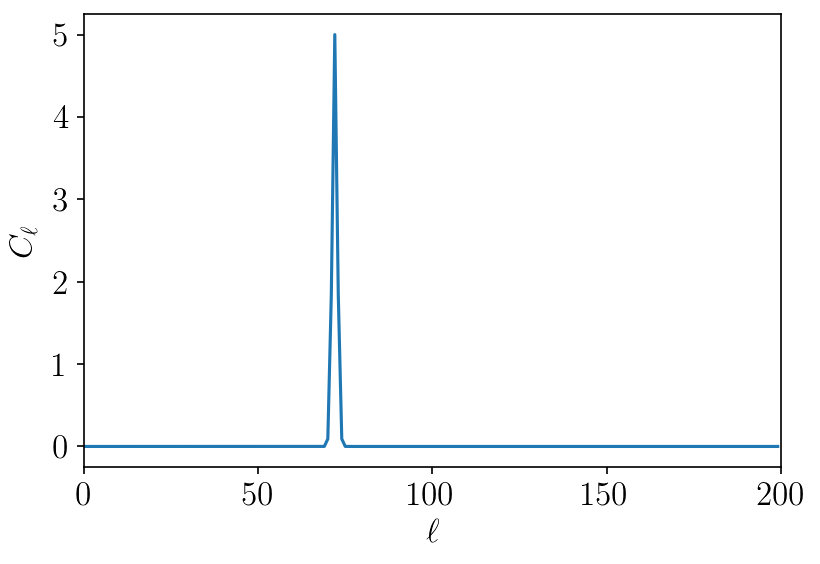

In [30]:
# construct an L array 
lmax = 200
L = np.arange(lmax)

# model the power spectrum as a sharp gaussian around ell=200

ell_peak = 72
C_peak = 5

C_ell = C_peak * np.exp(-(L-ell_peak)**2)

plt.plot(L,C_ell)
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

plt.xlim(0,lmax)

So far so good. Now this power spectrum corresponds to a map that only has fluctuations over the angular scale of $\ell=72$ or $\delta \theta = \pi/72$  radians, or 2.5 degrees. So if I simulate a map using this power spectrum (the underlying model) I should see that the size of the fluctuations are roughly 1 degree. 

`healpy` has a function that allows us to simulate $a_{\ell m}$s from a given $C_\ell$ called `synalm`.


In [31]:
# fix the seed for reproducibility
np.random.seed(5)
alm = hp.synalm(C_ell,lmax=lmax)

Let's check the histogram of the $a_{\ell m}$s to make sure the variance is equal to $C_\ell$.

Text(0.5, 0, '$a_{\\ell m}$')

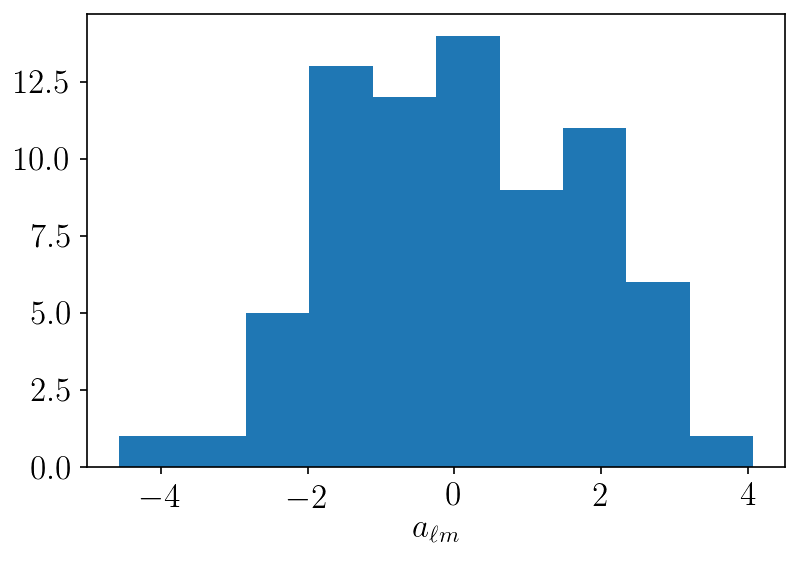

In [32]:
# slice the alms corresponding to ell_peak=72
idx = hp.Alm.getidx(lmax,ell_peak,np.arange(0,ell_peak+1))
_=plt.hist(alm[idx])
plt.xlabel("$a_{\ell m}$")

The mean and variance are respectively

In [33]:
np.mean(alm[idx])

(0.06982569322736747+0.30379103952793124j)

In [34]:
np.var(alm[idx])

5.149681974819684

which is roughly 5! very good...

Now in order to convert these $a_{\ell m}$s top a map (via Eq. \ref{eq:T_expansion}) we can use the `healpy.alm2map`:

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
70.89395573943362 99.10604426056639 -9.159927058021024 19.15992705802102
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 5 deg 0.00'.


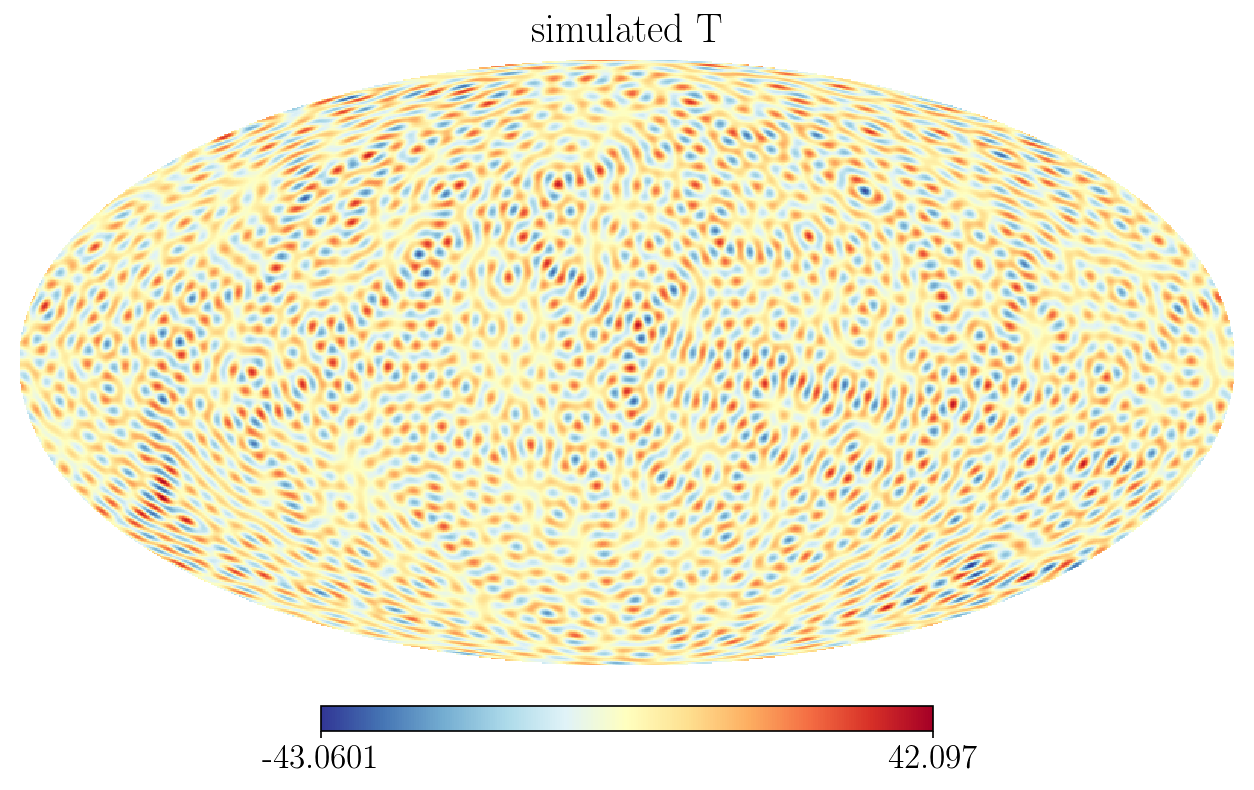

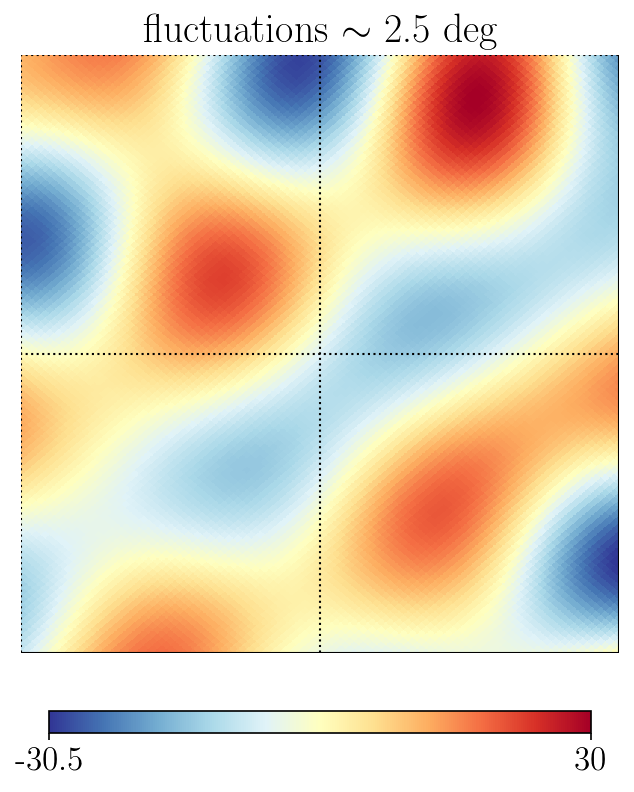

In [35]:
#convert alms to map
T_map = hp.alm2map(alm,
                   nside=3*lmax,
                  )

#plot the whole sky map
hp.mollview(T_map,
            title="simulated T",
            cmap=cmap)

#zoomin on a 10x10 sqr deg patch in cartesian coordinates
hp.cartview(T_map,
            title="fluctuations $\sim$ 2.5 deg",
            cmap=cmap,
            lonra=[0,10],
            latra=[0,10])

# plot grid lines every 5 degrees
hp.graticule(dpar=5,dmer=5)


Here in the zoomin The gridlines are 5 degrees apart. As expected, we have roughly two blobs (hot and cold spot) in each grid box, which indicates that the fluctuations are roughly 2.5 degrees apart ($\ell \sim 72$).  

---
>**Exercise:** Use the function `healpy.anafast` to convert the temperature map to a power spectrum and compare it with the theoretical one (`Cl_ell`). Are the two exactly the same? Should they be exactly the same? 

>Hint: why not?
    
---

---
>**Exercise:** Add a few extra peaks to the theoretical power spectrum and the convert it to a temperature map. Do the real space fluctuations correspond to your input in harmonic space?
    
---

# CMB statistics (in progress...)

So far we learned how to express the temperature of the CMB $T$ in terms of fluctuations over various angular scales ($a^T_{\ell m}$). But why is this useful and how does it help us quantify the CMB map any better? First, let's talk about how we can extract meaningful information from the CMB map. 

A single pixel $\hat{n} = (\theta, \phi)$ in the temperature map of the CMB (see the image at the beginning of this notebook) tells us how hot or cold the incoming radiation is towards an observer sitting on Earth (or roughly around it), looking in the direction $\hat{n}$. This is completely arbitrary and there is no cosmological theory/model that can predict what this number should be. So it is safe to say that the single pixel $T(\theta, \phi)$ by itself is pretty useless and uninformative. 


What models can predict, is the statistical (or ensemble) properties of $T(\theta, \phi)$: a model can tell us what we would find if we go to a lot of different places in the universe, measure the temperature of the CMB in the $\hat{n}$ (or any other arbitrary) direction, and then calculate different statistics of the measurements e.g. their ensemble average $T_0 = \langle T \rangle$, or variance $\langle (T-T_0)^2 \rangle$, etc. 

<span style="color:gray"> *Side Note*: I am using the word predict a bit loosely here. When I say cosmological models can predict statistical properties of the CMB temperature I don't mean they can divinely foretell its average value. What I mean is that the statistics of the CMB temperature can be meaningfully calculated based on a set of initial conditions via the model.</span>

No cosmological model aims to predict what the value of individual pixel temperatures $T(\hat{n})$ should be, but they can predict the average value of the temperature in said pixel. Perhaps Arthut Conan Doyle described this idea best when he said:

>While the individual man is an insoluble puzzle, in the aggregate he becomes a mathematical certainty. You can, for example, never foretell what any one man will do, but you can say with precision what an average number will be up to. —Sherlock Holmes, The Sign of the Four





Now a fun part of theoretical and numerical cosmology is to find statistics that are predictable by a model as well as measureable by experiments. This is great but obviously there is a caveat here. Let's say we have a prediction for the average temperature of the CMB (e.g. [Ralph Alpher & Robert Herman 1948](https://en.wikipedia.org/wiki/Cosmic_microwave_background#Microwave_background_radiation_predictions_and_measurements)) and you want to test it with observations. You can't actually go to different places in the universe and measure the CMB and then calculate the **ensemble average** $\langle T \rangle$...

Here the [ergodic theorem](https://en.wikipedia.org/wiki/Ergodic_theory) comes to rescue and allows us to replace teh ensemble average with a spacial average. The claim here is that the average value of a single pixel among many realizations of it (different places in the universe) is equal to the average of all the pixels in a single realization. 



## Correlation function 

In [31]:
Cl_fname = os.path.join("data","Cl_model.npz")
Cl_model = np.load(Cl_fname)

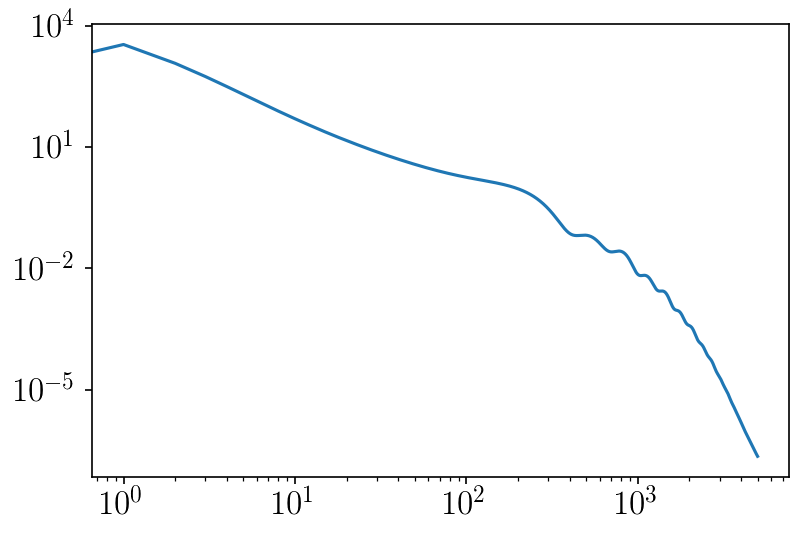

In [32]:
plt.loglog(Cl_model["TT"])